In [1]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=2,
    shuffle=True,
    num_workers=1
)

val = hydra.utils.instantiate(
    cfg.experiment.val_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

#batch = next(iter(train_dataloader))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset

)
trainer = pl.Trainer(
    max_epochs=cfg.experiment.max_epochs,
    enable_checkpointing=True,
    log_every_n_steps=1,
   # max_steps=cfg.experiment.max_steps if not cfg.debug else 10,
    precision="16-mixed",
    #precision='32',
    profiler='simple' if cfg.debug else None,
   # devices=cfg.experiment.num_gpus,
   # strategy='ddp_find_unused_parameters_true',
    #limit_train_batches=0.01 if cfg.debug else 1
    #limit_val_batches=0.01 if cfg.debug else 1,
    num_sanity_val_steps=2,
  #  device='cpu',
  #accelerator='mps',
  #CONV3D not supported by mps, have to use cpu when local 
    accelerator= 'mps' if cfg.environment.name == 'local' else 'gpu',
    fast_dev_run=10,
    limit_train_batches=0.001,
    limit_val_batches=0.001,
    
)


Seed set to 0
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using 16bit Automatic Mixed Precision (AMP)
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tens

In [2]:
trainer.test(model, val_dataloader)

/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


1.19744873046875 validation
1.2420654296875 validation
1.244842529296875 validation
1.24786376953125 validation
1.25030517578125 validation
1.2527313232421875 validation
1.2552337646484375 validation
1.257232666015625 validation
1.259246826171875 validation
1.2616119384765625 validation


[{}]

In [2]:
trainer.lightning_module.metrics.compute()

AttributeError: 'NoneType' object has no attribute 'metrics'

In [ ]:
batch = next(iter(val_dataloader))
history = model.sample_rollout(batch,lead_time_months=6)

(54, 12, 6)
[[[ 0.46894512  0.73063886  1.0770721   0.8593139   0.69586194
    0.6820412 ]
  [ 0.13076569  0.49986818  1.1484036   0.7519835   1.3629924
    0.46085218]
  [-0.06785025  0.18061374  0.64502627  0.35687354  0.9747673
    0.14479646]
  ...
  [-0.18610252  0.04796919  0.54157865  0.22707085  0.99368805
   -0.00399439]
  [-0.47101283 -0.27833477  0.1883017  -0.10967824  0.98247576
   -0.31855223]
  [-0.48959538 -0.37443522 -0.02332642 -0.23579144  0.7161842
   -0.3779687 ]]

 [[-0.58483493 -0.6350246  -0.64773077 -0.67651683  0.01611765
   -0.70351106]
  [-0.5062844  -0.66160214 -0.9786955  -0.86535126 -0.55360615
   -0.8098616 ]
  [-0.3491789  -0.29842997 -0.11561792 -0.24518286  0.29221997
   -0.33902344]
  ...
  [-0.6162748  -0.5777371  -0.38268855 -0.53765815  0.3861228
   -0.65258265]
  [-0.7446334  -0.6935276  -0.4357646  -0.62620574  0.52627623
   -0.76093036]
  [-0.7891002  -0.6858298  -0.2711274  -0.5339687   0.8142916
   -0.71299773]]

 [[-0.8914271  -0.8347612  -0

In [3]:
for index in range(len(history['state_surface'])):
    print(history['state_surface'][index].nanmean())

tensor(0.0023)
tensor(0.0024)
tensor(0.0025)
tensor(0.0026)
tensor(0.0027)
tensor(0.0027)


In [2]:
# trainer.fit(
#     model=model,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader)
# trainer.logged_metrics
checkpoint_path = torch.load(f'../epoch=30.ckpt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint_path['state_dict'])
# trainer.test(model, val_dataloader)
batch = next(iter(val_dataloader))

history = model.sample_rollout(batch)

(tensor([[[[-2.9513e-04, -1.5097e-02, -1.9873e-03,  ..., -1.3435e-02,
           -1.8366e-02, -2.1485e-02],
          [ 2.1875e-02,  1.1369e-02,  1.8362e-02,  ...,  6.3836e-03,
           -9.6746e-04, -1.2391e-02],
          [ 5.0241e-02,  5.8301e-02,  4.5672e-02,  ...,  4.8505e-02,
            5.0106e-02,  2.9790e-02],
          ...,
          [ 2.9128e-02,  4.0667e-02,  3.4941e-02,  ..., -1.9578e-03,
            1.0024e-02,  1.5852e-02],
          [ 2.3549e-02,  2.6881e-02,  2.4777e-02,  ...,  2.9794e-03,
            2.7827e-03, -4.6072e-03],
          [-3.4864e-02, -1.9771e-02, -1.4153e-02,  ..., -1.9525e-02,
           -2.7408e-02, -4.1489e-02]],

         [[-1.1538e-02, -9.4507e-03, -6.4011e-03,  ..., -1.9336e-03,
           -3.6196e-03, -1.0624e-02],
          [-2.2918e-03,  1.6096e-03,  2.0879e-03,  ..., -2.0007e-03,
           -1.9807e-04, -1.6354e-03],
          [-6.4007e-04,  1.6175e-03,  2.4255e-03,  ..., -6.7277e-05,
           -8.9442e-04,  3.7225e-03],
          ...,
    

In [9]:
for index in range(len(history['state_surface'])):
    print(history['state_surface'][index][0][3].nanmean())

tensor(-0.0099)
tensor(0.0147)
tensor(0.0235)
tensor(0.0321)
tensor(0.0272)
tensor(0.0205)
tensor(0.0209)
tensor(0.0105)
tensor(0.0161)
tensor(0.0114)
tensor(0.0087)
tensor(0.0122)


In [13]:
#denorm_surface = lambda x,month_index: x.to(device)*torch.from_numpy(train.surface_stds[month_index]).to(device) + torch.from_numpy(train.surface_means[month_index]).to(device)
month_index = 0
denormalized = []
for index in range(len(history['state_surface'])):

    denorm_surface = lambda x,month_index: x*torch.from_numpy(train.surface_stds[month_index]) + torch.from_numpy(train.surface_means[month_index])
    denormalized.append(denorm_surface(history['state_surface'][index],month_index))
    month_index += 1


In [18]:
for index in range(len(denormalized)):
    print(denormalized[index][0][0].nanmean())

tensor(274.9777)
tensor(275.6494)
tensor(276.4787)
tensor(277.1893)
tensor(278.9291)
tensor(280.3702)
tensor(281.2767)
tensor(280.4379)
tensor(279.8038)
tensor(278.6952)
tensor(277.6682)
tensor(277.8145)


In [24]:
batch['state_surface'][0][0].nanmean()

tensor(0.0081)

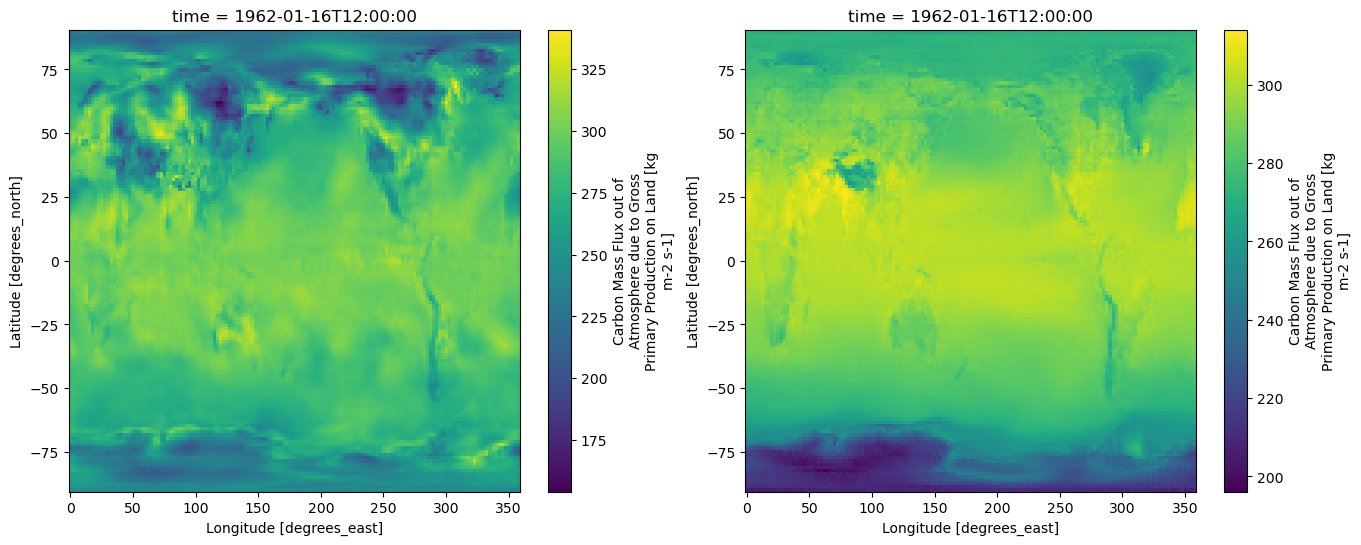

In [16]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = denormalized[0][0][0]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = denormalized[5][0][0]
shell[var_name].plot.pcolormesh(ax=ax2)

In [3]:
batch = next(iter(val_dataloader))

sample,batch,steps = model.sample(batch,scheduler='ddpm',num_inference_steps=50)


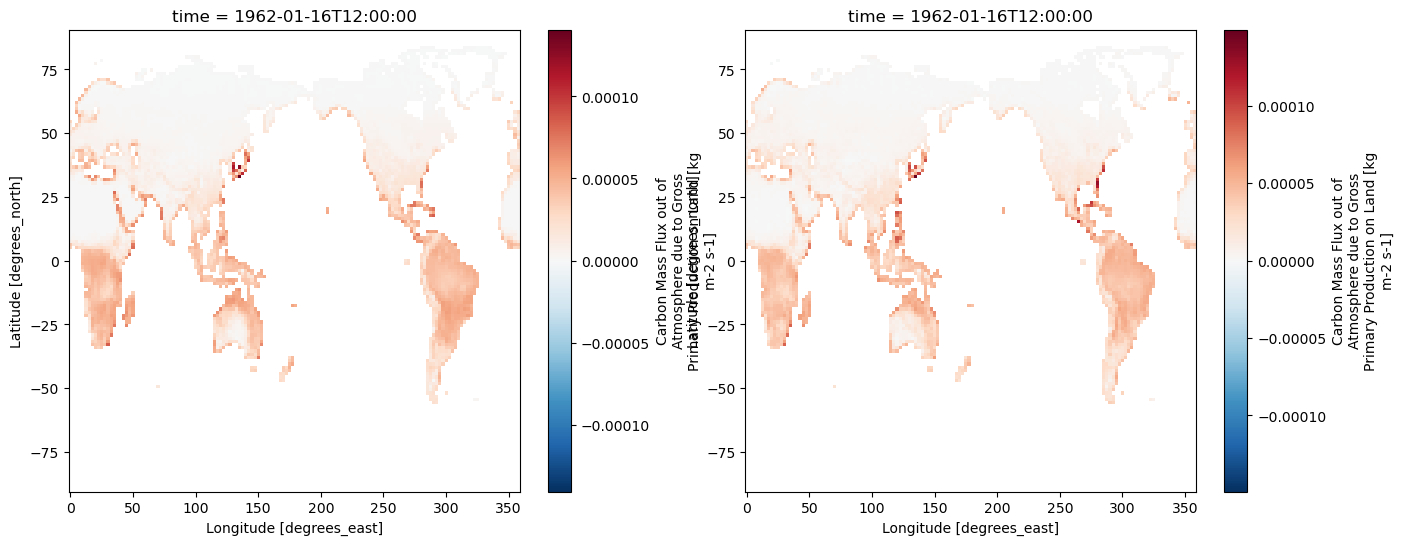

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = batch['next_state_surface'][0][5]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = sample['next_state_surface'][0][5]
shell[var_name].plot.pcolormesh(ax=ax2)

In [ ]:
# from celluloid import Camera
# fig, ax1 = plt.subplots(1, figsize=(16, 6))
# camera = Camera(fig)
# ax1.set_title("diffusion steps")
# ds = xr.open_dataset(val.files[0])
# shell = ds.isel(time=0)

# # Animate plot over time
# for time_step in range(len(steps)):
#     shell['tas'].data = steps[time_step][0,0,0]
#     shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
#     ax1.set_title(f"diffusion step {time_step}")    
#     camera.snap()
# anim = camera.animate()
# anim.save(f"diffusion.gif")

from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np


fig, ax1 = plt.subplots(1, figsize=(16, 6))
container = []
for time_step in range(len(steps)):
    shell['tas'].data = steps[time_step][0,4]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    line = shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
    title = ax1.text(0.5,1.05,"Diffusion Step {}".format(time_step), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax1.transAxes, )
    container.append([line, title])
plt.title('')

ani = animation.ArtistAnimation(fig, container, interval=100, blit=True)
ani.save("diffusion.gif")

In [ ]:
trainer.lightning_module.metrics.compute()